##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Monte Carlo Pricing in Tensorflow Quant Finance (TFF) using Euler Scheme

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
#@title Upgrade to TensorFlow 2.5+
!pip install --upgrade tensorflow

In [ ]:
#@title Install TF Quant Finance
!pip install tf-quant-finance

In [ ]:
#@title Install QuantLib
!pip install QuantLib-Python

In [ ]:
!nvidia-smi

Wed Aug 18 10:15:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

   Diffusion process $X(t) = (X_1(t), .. X_n(t))$ is a solution to a [Stochastic Differential Equation](https://en.wikipedia.org/wiki/Stochastic_differential_equation) (SDE)
   $$dS_i = a_i(t, S) dt + \sum_{j=1}^n S_{ij} (t, S) dW_j,\ i \in \{1,.., n\},$$

where $n$ is the dimensionality of the diffusion, $\{W_j\}_{j=1}^n$ is $n$-dimensitonal Brownian motion, $a_i(t, S)$ is the instantaneous drift rate and the $S_{ij}(t)$ is the
volatility matrix.

In this colab we demonstrate how to draw samples from the difusion solution in TFF using the [Euler scheme](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method). We also demonstrate how to use automatic differentiation framework for vega and delta computation and provide performance benchmarks.


In [ ]:
#@title Imports { display-mode: "form" }

import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf

import QuantLib as ql

 # tff for Tensorflow Finance
import tf_quant_finance as tff

from IPython.core.pylabtools import figsize
figsize(21, 14) # better graph size for Colab  


## Setting up the Euler sampling for European call option pricing under Black-Scholes

The pricing function outputs prices on the grid `expiries x strikes`.

Sampling is performed using `sample_paths` method of `GenericItoProcess` class. The user is free to provide their own drift and volatility function in order to sample from the desired process.

For many processes there exist efficient specialized samplers and the user should feel free to explore the TFF [models module](https://github.com/google/tf-quant-finance/tree/master/tf_quant_finance/models).

In this example, however, we consider only `GenericItoProcess`.



In [ ]:
#@title Set up parameters

dtype = np.float64 #@param
num_samples = 200000 #@param

num_timesteps = 100 #@param

expiries = [1.0] # This can be a rank 1 Tensor
dt = 1. / num_timesteps
rate = tf.constant(0.03, dtype=dtype)
sigma = tf.constant(0.1, dtype=dtype)
spot = tf.constant(700, dtype=dtype)

strikes = tf.constant([600, 650, 680], dtype=dtype)

def set_up_pricer(expiries, watch_params=False):
    """Set up European option pricing function under Black-Scholes model.
    
    Args:
        expiries: List of expiries at which to to sample the trajectories.
        watch_params: A Python bool. When `True`, gradients of the price function wrt the inputs
          are computed more efficiently. 
    Returns:
     A callable that accepts a rank 1 tensor of strikes, and scalar values for 
     the spots and  volatility values. The callable outputs prices of
     the European call options on the grid `expiries x strikes`.
    """
    def price_eu_options(strikes, spot, sigma):
        # Define drift and volatility functions. 
        def drift_fn(t, x):
          del t, x
          return rate - 0.5 * sigma**2
        def vol_fn(t, x):
          del t, x
          return tf.reshape(sigma, [1, 1])
        # Use GenericItoProcess class to set up the Ito process
        process = tff.models.GenericItoProcess(
            dim=1,
            drift_fn=drift_fn,
            volatility_fn=vol_fn,
            dtype=dtype)
        log_spot = tf.math.log(tf.reduce_mean(spot))
        if watch_params:
            watch_params_list = [sigma]
        else:
            watch_params_list = None
        paths = process.sample_paths(
            expiries, num_samples=num_samples,
            initial_state=log_spot, 
            watch_params=watch_params_list,
            # Select a random number generator
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)
        prices = (tf.exp(-tf.expand_dims(rate * expiries, axis=-1))
                  * tf.reduce_mean(tf.nn.relu(tf.math.exp(paths) - strikes), 0))
        return prices
    return price_eu_options

price_eu_options = tf.function(set_up_pricer(expiries))


In [ ]:
#@title Pricing time a CPU. Note TensorFlow does automatic multithreading.

# First run (includes graph optimization time)
with tf.device("/cpu:0"):
    price_eu_options(strikes, spot, sigma)

# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()

time_price_cpu = time_end - time_start
print("Time (seconds) to price a European Call Option on a CPU: ", time_price_cpu)

Time (seconds) to price a European Call Option on a CPU:  2.1619842052459717


### Better performance with XLA

A quick guide on XLA is available on [TensorFlow website](https://www.tensorflow.org/xla).
Roughly, XLA compiler generates a binary for the desired architecture (CPU/GPU/TPU). When underlying TF graph consists of
many nodes, XLA might provide a significant speed up.

Below we use `tf.function` with `jit_compile=True` to indicate that the whole Monte Carlo graph should be XLA-compiled.

In [ ]:
price_eu_options_xla = tf.function(set_up_pricer(expiries), jit_compile=True)

In [ ]:
#@title Pricing times on a CPU with XLA compilation

# First run (includes graph optimization time)
with tf.device("/cpu:0"):
    price_eu_options_xla(strikes, spot, sigma)

# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()

time_price_cpu_xla = time_end - time_start
print("Time (seconds) to price a European Call Option on a CPU with XLA: ", time_price_cpu_xla)

Time (seconds) to price a European Call Option on a CPU with XLA:  0.7147080898284912


### For the reference we provide performance of the Monte Carlo pricer in QuantLib

In [ ]:
#@title Monte Carlo sampling in QuantLib

num_samples = 200000 #@param

num_timesteps = 100 #@param

expiry = 1.0

calculation_date = ql.Date(1, 1, 2010)
maturity_date = ql.Date(1, 1, 2011)
day_count = ql.Thirty360()
calendar = ql.NullCalendar()

ql_strike_price = 550
sigma_ql = 0.1
ql_volatility = ql.SimpleQuote(sigma_ql)
ql_risk_free_rate = 0.03
option_type = ql.Option.Call

ql.Settings.instance().evaluationDate = calculation_date
payoff = ql.PlainVanillaPayoff(option_type, ql_strike_price)

eu_exercise = ql.EuropeanExercise(maturity_date)
european_option_ql = ql.VanillaOption(payoff, eu_exercise)

flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, ql_risk_free_rate, day_count)
)
flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar,
                        ql.QuoteHandle(ql_volatility), day_count)
)

spot_ql = 700
spot_price = ql.SimpleQuote(spot_ql)
spot_handle = ql.QuoteHandle(
    spot_price
)
bsm_process = ql.BlackScholesProcess(spot_handle,
                                      flat_ts,
                                      flat_vol_ts)

# Compute the same price number_of_options times

engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                             timeSteps=num_timesteps,
                             requiredSamples=num_samples,
                             seed=42)

european_option_ql.setPricingEngine(engine)
# Price
t = time.time()
price_ql = european_option_ql.NPV()
time_price_ql = time.time() - t
print("Time (seconds) to price a European Call Option using QuantLib: ", time_price_ql)


Time (seconds) to price a European Call Option using QuantLib:  11.273834705352783


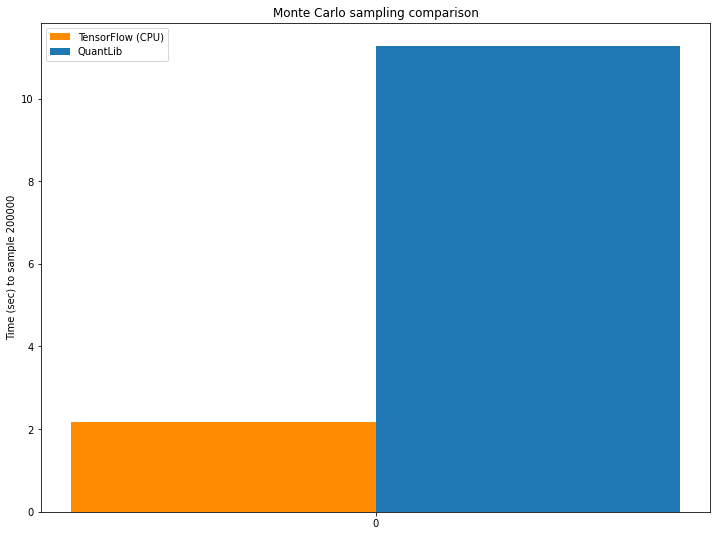

In [ ]:
#@title Plot the results

ind = np.arange(1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(12)

ax.bar(ind - width/2, [time_price_cpu], width,
       label='TensorFlow (CPU)', color='darkorange')
ax.bar(ind + width/2, [time_price_ql], width,
       label='QuantLib')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec) to sample {}'.format(num_samples))
ax.set_title('Monte Carlo sampling comparison')
ax.set_xticks(ind)
ax.legend()


plt.show()

# GPU vs CPU performace

Above one can see that TF effectively applies multithreading to achieve the best possible CPU performance. If the user has access to a good GPU, additional boost can be achieved as demonstrated below.

For this specific model XLA provides significant speedup for both CPU and GPU
platforms.

Tesla V100 provides 100x speed up compared to a cloud CPU with 8 logical cores
(`n1-standard-8` machine type on Google Cloud Platform).

In [ ]:
#@title Pricing times on CPU and GPU platforms

# CPU without XLA
with tf.device("/cpu:0"):
    price_eu_options(strikes, spot, sigma)
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_cpu = time_end - time_start

# CPU with XLA
with tf.device("/cpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_cpu_xla = time_end - time_start

# GPU without XLA
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_gpu = time_end - time_start

# GPU with XLA
with tf.device("/gpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_gpu_xla = time_end - time_start


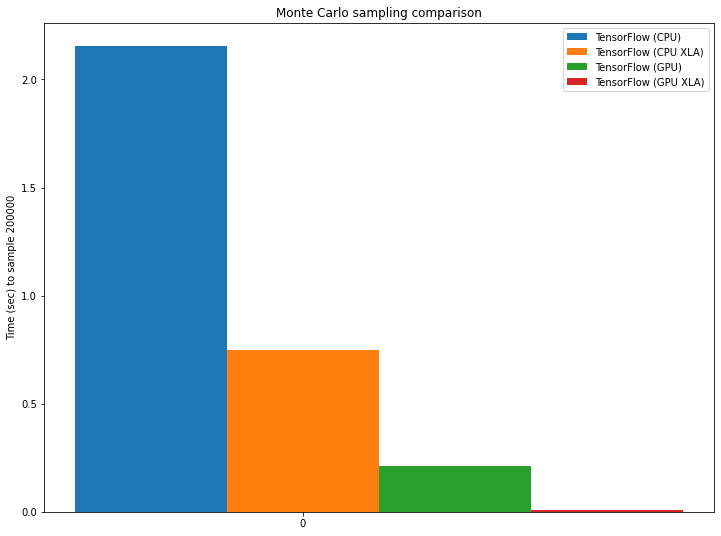

In [ ]:
#@title Plot the results

ind = np.arange(1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(12)

ax.bar(ind - width/8, [time_price_cpu], width / 8,
       label='TensorFlow (CPU)')
ax.bar(ind, [time_price_cpu_xla], width / 8,
       label='TensorFlow (CPU XLA)')
ax.bar(ind + width/8, [time_price_gpu], width / 8,
       label='TensorFlow (GPU)')
ax.bar(ind + width/4, [time_price_gpu_xla], width / 8,
       label='TensorFlow (GPU XLA)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec) to sample {}'.format(num_samples))
ax.set_title('Monte Carlo sampling comparison')
ax.set_xticks(ind)
ax.legend()


plt.show()

# Greek computation 

TF provides framework for automatic differentiation. Below we demostrate how to compute vega and delta for the European call options and compare the estimated results ti the true values.

In [ ]:
# Set up the pricer
expiries = [0.5, 1.0]
strikes = tf.constant([600, 650, 680], dtype=dtype)
sigma = tf.constant(0.1, dtype=dtype)
price_eu_options = set_up_pricer(expiries, watch_params=True)

In [ ]:
price_eu_options_no_watched_params = set_up_pricer(expiries)
@tf.function(jit_compile=True)
def price_eu_options_xla(strikes, spot, sigma):
    return price_eu_options_no_watched_params(strikes, spot, sigma)

@tf.function
def vega_fn(sigma):
    fn = lambda sigma: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, sigma,
                                 use_gradient_tape=True)

@tf.function(jit_compile=True)
def vega_fn_xla(sigma):
    return vega_fn(sigma)

@tf.function
def delta_fn(spot):
    fn = lambda spot: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, spot,
                                 use_gradient_tape=True)

@tf.function(jit_compile=True)
def delta_fn_xla(spot):
    return delta_fn(spot)

In [ ]:
estimated_deltas = delta_fn_xla(spot)
print("Estimated deltas on grid expiries x strikes: \n", estimated_deltas.numpy())

Estimated deltas on grid expiries x strikes: 
 [[0.99248277 0.90309587 0.74544609]
 [0.97055601 0.86385565 0.73988398]]


In [ ]:
estimated_vegas = vega_fn_xla(sigma)
print("Estimated vegas on grid expiries x strikes: \n", estimated_vegas.numpy())

Estimated vegas on grid expiries x strikes: 
 [[  9.56612853  83.84885948 158.35179387]
 [ 46.27546525 153.31475986 226.91236681]]


In [ ]:
expiries_tensor = tf.expand_dims(tf.convert_to_tensor(expiries, dtype=dtype), axis=1)
true_delta_fn = lambda spot : tff.black_scholes.option_price(volatilities=sigma,
                                                             strikes=strikes,
                                                             spots=spot,
                                                             expiries=expiries_tensor,
                                                             discount_rates=rate)
true_vega_fn = lambda sigma : tff.black_scholes.option_price(volatilities=sigma,
                               strikes=strikes,
                               spots=spot,
                               expiries=expiries_tensor,
                               discount_rates=rate)

In [ ]:
true_delta = tff.math.fwd_gradient(true_delta_fn, spot)
true_vega = tff.math.fwd_gradient(true_vega_fn, sigma)
print("True deltas on grid expiries x strikes: \n", true_delta.numpy())
print("True vegas on grid expiries x strikes: \n", true_vega.numpy())

True deltas on grid expiries x strikes: 
 [[0.99239851 0.90243168 0.74454875]
 [0.97072164 0.8623811  0.73887319]]
True vegas on grid expiries x strikes: 
 [[ 10.37265092  85.31635365 159.08825372]
 [ 46.67659297 153.994105   227.5617336 ]]


In [ ]:
print("Relative error in delta estimation: \n", np.max(abs(estimated_deltas - true_delta) / true_delta))
print("Relative error in vega estimation: \n", np.max(abs(estimated_vegas - true_vega) / true_vega))


Relative error in delta estimation: 
 0.0017098568942449592
Relative error in vega estimation: 
 0.0777547026302402


In [ ]:
#@title Greek computation speed

# Price CPU with XLA
## warmup
with tf.device("/cpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
## measure time
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_cpu = time_end - time_start

# Delta CPU with XLA
## warmup
with tf.device("/cpu:0"):
    delta_fn_xla(spot)
## measure time
time_start = time.time()
with tf.device("/cpu:0"):
    delta_fn_xla(spot)
time_end = time.time()
time_delta_cpu = time_end - time_start

# Vega CPU with XLA
## warmup
with tf.device("/cpu:0"):
    vega_fn_xla(spot)
## measure time
time_start = time.time()
with tf.device("/cpu:0"):
    vega_fn_xla(spot)
time_end = time.time()
time_vega_cpu = time_end - time_start

# Price GPU with XLA
## warmup
with tf.device("/gpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
## measure time
time_start = time.time()
with tf.device("/gpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_gpu = time_end - time_start

# Delta GPU with XLA
## warmup
with tf.device("/gpu:0"):
    delta_fn_xla(spot)
## measure time
time_start = time.time()
with tf.device("/gpu:0"):
    delta_fn_xla(spot)
time_end = time.time()
time_delta_gpu = time_end - time_start

# Vega GPU with XLA
## warmup
with tf.device("/gpu:0"):
    vega_fn_xla(spot)
## measure time
time_start = time.time()
with tf.device("/gpu:0"):
    vega_fn_xla(spot)
time_end = time.time()
time_vega_gpu = time_end - time_start

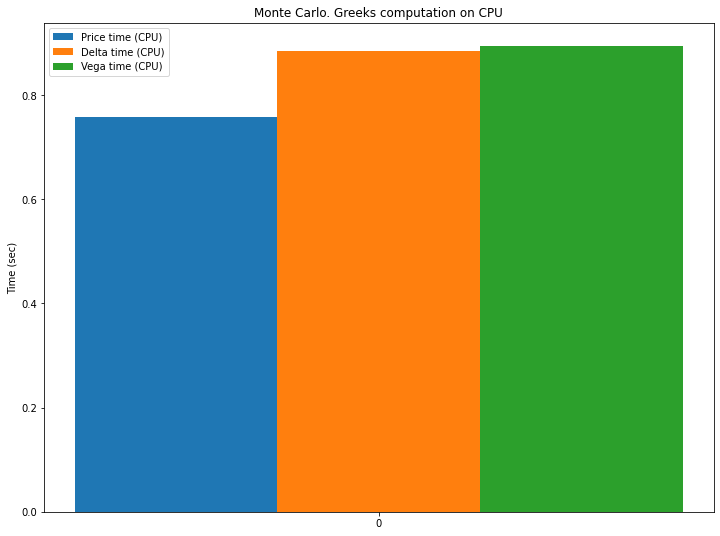

In [ ]:
#@title CPU greeks computation speed

ind = np.arange(1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(12)

ax.bar(ind - width/8, [time_price_cpu], width / 8,
       label='Price time (CPU)')
ax.bar(ind, [time_delta_cpu], width / 8,
       label='Delta time (CPU)')
ax.bar(ind + width/8, [time_vega_cpu], width / 8,
       label='Vega time (CPU)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec)')
ax.set_title('Monte Carlo. Greeks computation on CPU')
ax.set_xticks(ind)
ax.legend()


plt.show()

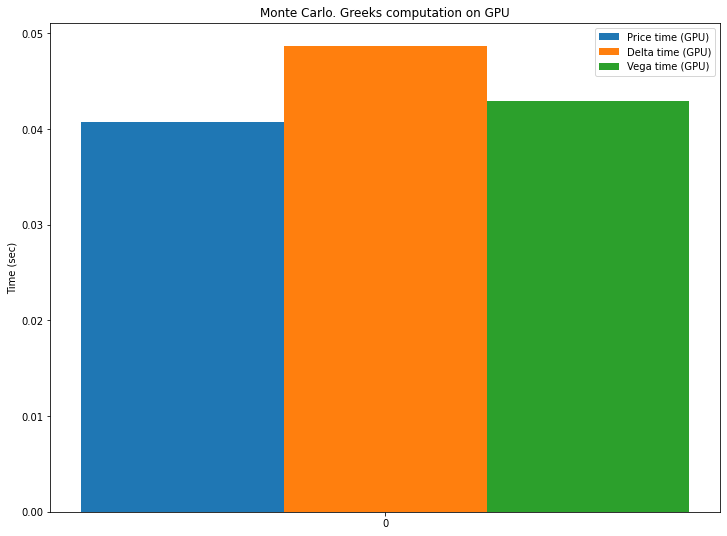

In [ ]:
#@title GPU greeks computation speed

ind = np.arange(1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(12)

ax.bar(ind - width/8, [time_price_gpu], width / 8,
       label='Price time (GPU)')
ax.bar(ind, [time_delta_gpu], width / 8,
       label='Delta time (GPU)')
ax.bar(ind + width/8, [time_vega_gpu], width / 8,
       label='Vega time (GPU)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec)')
ax.set_title('Monte Carlo. Greeks computation on GPU')
ax.set_xticks(ind)
ax.legend()


plt.show()